# Example notebook for STM analysis with python
## Singular value decomposition
### Steven R. Schofield, May 2021

In [32]:
# The commands in this box are just things to make the notebook a little nicer, and to clear variables
# and make sure any module changes are reloaded.

# These "magic" commands ensure a module is reloaded if it has been changed
%load_ext autoreload
%autoreload 2

# This turns off the warnings that come in pycroscopy regarding future changes. 
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)  

# Make Notebook take up most of page width
from IPython.core.display import HTML
display(HTML(data="""
<style>
    div#notebook-container    { width: 99%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
# Some pages relevant to the modules listed below. 
#
# https://nbviewer.jupyter.org/github/pycroscopy/papers/blob/master/HTML/EM/STEM/Image_Cleaning_Atom_Finding.html
#
# https://pycroscopy.github.io/pycroscopy/papers_conferences.html

In [34]:
# LOAD REQUIRED MODULES 

# General utilities, file io etc. 
import os
import sys

# For calculating time taken
from time import time

# File format
import h5py        # h5py file format

# Pycroscopy modules
import pycroscopy as px # Scientific analysis of nanoscale materials imaging data
import pyUSID as usid   # Framework for storing, visualizing, and processing Universal Spectroscopic and Imaging Data (USID)
import sidpy            # Supporting package for pyUSID utilities for storing and visualizing Spectroscopic and Imaging Data (USID)

# General image analysis (not pyscroscopy)
import spiepy                # Scanning Probe Image Enchanter using Python: is a Python library to improve automatic processing of SPM images.

# Math 
import numpy as np # The fundamental package for scientific computing with Python, particularly involving arrays

# Visualization:
import matplotlib.pyplot as plt

In [35]:
# LOAD SRS module for loading Scienta Omicron data.

# get the path of this notebook.  I'm assuming my module and the data are in ../SRS and ../data...
current_path = os.getcwd()
sys.path.append('..')

# My module for using MTRX format data with pycroscopy.
import SRSML as spm

In [36]:
# Folder containing the data to be loaded

# Si(111):B
dataFilePath = "../data/MTRX/11-Jun-2014"
# Name of the image to be analysed
imgFileName='default_2014Jun11-163508_STM-STM_Spectroscopy--57_1.Z_mtrx'

# Ge(001):AsH3
dataFilePath = "../data/MTRX/5-Mar-2020"
# Name of the image to be analysed
imgFileName='default_2020Mar05-185936_STM-STM_Spectroscopy--9_38.Z_mtrx'

# Path where the MTRX data is
dataFilePath = "../data/MTRX/15-Jun-2014" 

# Name of the image to be analysed
imgFileName='default_2014Jun15-190130_STM-STM_Spectroscopy--41_1.Z_mtrx'

In [37]:
# Read the MTRX data, then write this to disk as h5USID format. 
h5OrigFileName = spm.MTRXtoh5USID(dataFilePath,imgFileName)
                              
# Display the plane subtracted data from the previous step.
#spm.h5_plot_MTRXformat(h5OrigFileName)

The current folder is: /Users/steven/academic/calc/Python/srs-ml/work-srs
Will attempt to open file: /Users/steven/academic/calc/Python/srs-ml/work-srs/../data/MTRX/15-Jun-2014/default_2014Jun15-190130_STM-STM_Spectroscopy--41_1.Z_mtrx
Saving H5USID file in directory ../data/H5USID
Name of h5USID file saved: ../data/H5USID/default_2014Jun15-190130_STM-STM_Spectroscopy--41_1.h5
Writing h5 file: 
../data/H5USID/default_2014Jun15-190130_STM-STM_Spectroscopy--41_1.h5


In [38]:
# Get just one of the images, e.g., forward up
h5SingleImageFileName = spm.h5_manipulate(h5OrigFileName,selectone='BD')

Writing h5 file: 
../data/H5USID/default_2014Jun15-190130_STM-STM_Spectroscopy--41_1FU.h5


In [39]:
#spm.h5_plot_MTRXformat(h5SingleImageFileName)

In [40]:
# Get just one of the images, e.g., forward up
h5SingleImageBGFileName = spm.h5_manipulate(h5SingleImageFileName,background='plane2')

Writing h5 file: 
../data/H5USID/default_2014Jun15-190130_STM-STM_Spectroscopy--41_1FUp2.h5


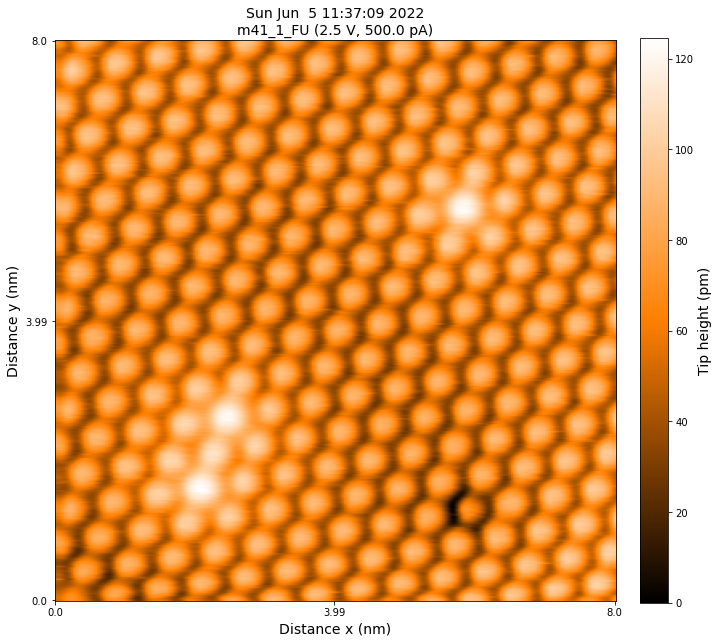

In [41]:
# Display the plane subtracted FU data from the previous step.
spm.h5_plot_MTRXformat(h5SingleImageBGFileName)

## Start data analysis

In [42]:
# open the h5USID file
h5File = h5py.File(h5SingleImageBGFileName, mode='r+')
_ = sidpy.hdf.hdf_utils.print_tree(h5File)

/
├ Topography_000
  --------------
  ├ Forward_Up_000
    --------------
    ├ Position_Indices
    ├ Position_Values
    ├ Spectroscopic_Indices
    ├ Spectroscopic_Values
    ├ m41_1_FU


In [43]:
# Get the image as numpy array and calculate its size
h5img = usid.hdf_utils.get_all_main(h5File)[-1]
#h5Pos = h5img.h5_pos_inds                         # grab position indices from the H5 file
imgRows, imgCols = h5img.pos_dim_sizes            # determine the image size:
print('\nThe original image has {} rows, {} columns, and therefore {} pixels.'.format(imgRows, imgCols, imgRows * imgCols))



The original image has 350 rows, 350 columns, and therefore 122500 pixels.


## Create the image windows from the full image

In [14]:
_ = sidpy.hdf.hdf_utils.print_tree(h5File)

/
├ Topography_000
  --------------
  ├ Forward_Up_000
    --------------
    ├ Position_Indices
    ├ Position_Values
    ├ Spectroscopic_Indices
    ├ Spectroscopic_Values
    ├ m41_1_FU


In [52]:
## Choose a window size and plot an example window.
winSize=25

# Initialise image window class on image main dataset
iw = px.processing.ImageWindow(h5img, max_RAM_mb=1024*4)

# Windowing the data
t0 = time()
h5Windows = iw.do_windowing(win_x=winSize,win_y=winSize,save_plots=False,show_plots=False,win_fft='data+abs')
print( 'Windowing took {} seconds.'.format(round(time()-t0, 2)))

Determining appropriate window size from image.
Optimal window size determined to be 25x25 pixels.


TypeError: write_simple_attrs() got an unexpected keyword argument 'obj_type'

In [16]:
print('\nRaw data was of shape {} and the windows dataset is now of shape {}'.format(h5img.shape, h5Windows.shape))
print('Now each position (window) is descibed by a set of pixels')

NameError: name 'h5Windows' is not defined

In [17]:
_ = sidpy.hdf.hdf_utils.print_tree(h5File)

/
├ Topography_000
  --------------
  ├ Forward_Up_000
    --------------
    ├ Position_Indices
    ├ Position_Values
    ├ Spectroscopic_Indices
    ├ Spectroscopic_Values
    ├ m41_1_FU
    ├ m41_1_FU-Windowing_000
      ----------------------
      ├ Image_Windows


In [18]:
# View some of the windows 
#windowsReshaped = np.reshape(h5Windows[()]['Image Data'].T,[winSize,winSize,-1])
#numWindowPlotComps = 25
#figW, axW = sidpy.viz.plot_utils.image.plot_map_stack(windowsReshaped.T, 
#                                title='', subtitle='Window', num_comps=numWindowPlotComps,cmap=spiepy.NANOMAP)

## SVD

In [19]:
# Limiting SVD components seems to cause problems with the KMeans function later.  But also, having a lot of SVD components 
# also causes problems with the KMeans.  So, need to find appropriate image/window size combinations (I think)...

# SVDComponentNumberLimit = 150
# numSVDComp = min(winSize*winSize,SVDComponentNumberLimit) # Set how many SVD components to use
# print('The value of winSize*winSize is {}.  Using {} SVD components.'.format(winSize*winSize,numSVDComp))

numSVDComp = 250
print('Number of SVD components is {}.'.format(numSVDComp))
if numSVDComp > 250:
    print('WARNING!! This number may be too large.  Consider reducing the size of winSize so that numSVDComp < 250.')

Number of SVD components is 250.


In [20]:
h5processing = px.processing.SVD(h5Windows,num_components=numSVDComp)
h5SVD = h5processing.compute()

NameError: name 'h5Windows' is not defined

In [21]:
_ = sidpy.hdf.hdf_utils.print_tree(h5File)

/
├ Topography_000
  --------------
  ├ Forward_Up_000
    --------------
    ├ Position_Indices
    ├ Position_Values
    ├ Spectroscopic_Indices
    ├ Spectroscopic_Values
    ├ m41_1_FU
    ├ m41_1_FU-Windowing_000
      ----------------------
      ├ Image_Windows


In [22]:
# Assigning U, sigma and V datasets to variables
h5U = h5SVD['U']
h5S = h5SVD['S']
h5V = h5SVD['V']

NameError: name 'h5SVD' is not defined

In [23]:
# Checking amount of components SVD gave us

print("There are a total of {} components (eigenvalues).".format(numSVDComp))
print('\nRaw data was of shape {} and the windows dataset is now of shape {}'.format(h5img.shape, h5Windows.shape))
print('Now each position (window) is descibed by a set of {} x {} = {} pixels'.format(winSize, winSize, winSize*winSize))

There are a total of 250 components (eigenvalues).


NameError: name 'h5Windows' is not defined

In [24]:
# Grabbing position indices and num of rows and cols
h5Positions = iw.hdf.file[h5Windows.attrs['Position_Indices']]
# Use this to get the number of window rows and columns
numWindowRows = len(np.unique(h5Positions[:, 0]))
numWindowCols = len(np.unique(h5Positions[:, 1]))
print('Number of window rows and columns is {}, {}.'.format(numWindowRows, numWindowCols))
print('This should correspond to the original image size, {}, {}, minus the window size, plus 1, {}, {}, i.e., {}. {}.'.format(imgRows, imgCols, winSize, winSize,imgRows-winSize+1, imgCols-winSize+1))

NameError: name 'h5Windows' is not defined

In [25]:
h5Ureshaped = np.reshape(h5U, [numWindowRows, numWindowCols, -1])
h5Vreshaped = np.reshape(h5V, [numSVDComp, winSize, winSize])
h5Vreshaped = np.transpose(h5Vreshaped,(2,1,0))
# The U matrices are simple numpy arrays, but the V matrices can be "Image data" (or, I think 'FFT' or something, I'm not certain...)

print('The shape of the U matrix is {}'.format(h5Ureshaped.shape))
print('The shape of the S (sigma) matrix is {}'.format(h5S.shape))
print('The shape of the V matrix is {}'.format(h5Vreshaped.shape))


NameError: name 'h5U' is not defined

In [26]:
# Plotting log-log plot of sigma values against num of components
figS, axS = usid.plot_utils.plot_scree(h5S[()]);

NameError: name 'h5S' is not defined

### V (Eigenvectors)
#### The V dataset contains the eigenvectors for each component

In [27]:
numEigenPlotComps = 15
for field in h5V.dtype.names:
    figU, axU = sidpy.viz.plot_utils.image.plot_map_stack(h5Vreshaped[:,:,:][field].T, 
                                title='', subtitle='Eigen-window', num_comps=numEigenPlotComps,cmap=spiepy.NANOMAP)

NameError: name 'h5V' is not defined

### U (Eigenvalues or loading maps):
#### The plot below shows the spatial distribution of each component

In [28]:
figU, axU = sidpy.viz.plot_utils.image.plot_map_stack(h5Ureshaped[:,:,:].T, 
                                title='', subtitle='Eigen-window', num_comps=numEigenPlotComps,cmap=spiepy.NANOMAP)

NameError: name 'h5Ureshaped' is not defined

In [29]:
# Rebuild the image
cleanComponentsRange = range(numSVDComp) # It seems like this should be able to be set, but it fails if set to anything but the same size at the SVD.

#h5_clean_image = iw.clean_and_build_batch(h5_win=h5_wins, components=clean_components)
t0 = time()
h5CleanImage = iw.clean_and_build_separate_components(h5_win=h5Windows, components=cleanComponentsRange)
print('iw.clean_and_build_separate_components took {} seconds.'.format(round(time()-t0, 2)))

NameError: name 'h5Windows' is not defined

In [30]:
_ = sidpy.hdf.hdf_utils.print_tree(h5File)

/
├ Topography_000
  --------------
  ├ Forward_Up_000
    --------------
    ├ Position_Indices
    ├ Position_Values
    ├ Spectroscopic_Indices
    ├ Spectroscopic_Values
    ├ m41_1_FU
    ├ m41_1_FU-Windowing_000
      ----------------------
      ├ Image_Windows


In [ ]:
# Sum the image components
cleanImageVec = h5CleanImage[()]

#cleanImageVecsumLimit = min(150,h5CleanImage.shape[1])
cleanImageVecsumLimit = h5CleanImage.shape[1]

t0 = time()
for index in range(1, cleanImageVecsumLimit):
    cleanImageVec[:, index] = np.sum(h5CleanImage[:, :index+1], axis=1)
print('Summing image components up to {} took {} minutes.'.format(cleanImageVecsumLimit, round((time()-t0)/60, 2)))

# Reshape the summed components into image shape
cleanImageVecReshaped = np.reshape(cleanImageVec, [imgRows, imgCols, numSVDComp])

In [ ]:
figC, axC = usid.plot_utils.plot_map_stack(cleanImageVecReshaped.T, title='', evenly_spaced=False,
                                       subtitle='Component', num_comps=numEigenPlotComps, color_bar_mode='single', 
                                       cmap=spiepy.NANOMAP)

## Atom Finding
#### We will attempt to find the positions and the identities of atoms in the image now

### Perform clustering on the dataset
#### Clustering divides data into k clusters such that the variance within each cluster is minimized. Here, we will be performing k-means clustering on a set of components in the U matrix from SVD. We want a large enough number of clusters so that K-means identifies fine nuances in the data. At the same time, we want to minimize computational time by reducing the number of clusters. We recommend 32 - 64 clusters.

In [ ]:
# calculating the removed noise:
noiseVecReshaped = cleanImageVecReshaped - np.reshape(np.tile(h5img[()], [1, h5CleanImage.shape[1]]), cleanImageVecReshaped.shape)

In [ ]:
# Get FFT components

# defining a helper function to get the FFTs of a stack of images
def get_fft_stack(image_stack):
    blackman_window_rows = np.blackman(image_stack.shape[0])
    blackman_window_cols = np.blackman(image_stack.shape[1])
    fft_stack = np.zeros(image_stack.shape, dtype=np.float)
    for image_ind in range(image_stack.shape[2]):
        layer = image_stack[:, :, image_ind]
        windowed = blackman_window_rows[:, np.newaxis] * layer * blackman_window_cols[np.newaxis, :]
        fft_stack[:, :, image_ind] = np.abs(np.fft.fftshift(np.fft.fft2(windowed, axes=(0,1)), axes=(0,1)))
    return fft_stack

# get the FFT of the cleaned image and the removed noise:
fftImageComponents = get_fft_stack(cleanImageVecReshaped)
fftNoiseComponents = get_fft_stack(noiseVecReshaped)

In [ ]:
import ipywidgets as widgets

# Choose the initial number of components to include
numPlotComps = round(0.65 * cleanImageVecsumLimit)

# Create blank subfigure panels
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 14))

# Eigenvalue plot
_ = axes.flat[0].semilogy(h5S[:], '*-')
_ = axes.flat[0].set_xlim(left=1, right=h5S[:].size)
_ = axes.flat[0].set_ylim(bottom=np.min(h5S[:]), top=np.max(h5S[:]))
_ = axes.flat[0].set_xlabel('Component (number)', fontsize = 20)
_ = axes.flat[0].set_ylabel('Variance (eigenvalue)', fontsize = 20)
vert_line = axes.flat[0].axvline(x=numPlotComps, color='r')

# Display the cleaned image corresponding to the chosen maximum component number
filteredImgNp = cleanImageVecReshaped[:,:,numPlotComps]
img_clean = axes.flat[1].imshow(filteredImgNp, cmap=spiepy.NANOMAP)
_ = axes.flat[1].get_yaxis().set_visible(False)
_ = axes.flat[1].get_xaxis().set_visible(False)
_ = axes.flat[1].set_title('Cleaned Image', fontsize=16)

# Calculate the colour range for FFT
fft_std_dev =  np.max(np.std(fftImageComponents[:, :, numPlotComps]))

# Plot the noise FFT
img_noise_fft = axes.flat[2].imshow(fftNoiseComponents[:, :, numPlotComps], cmap=plt.cm.jet, vmin=0, vmax=4*fft_std_dev)
axes.flat[2].get_yaxis().set_visible(False)
axes.flat[2].get_xaxis().set_visible(False)
axes.flat[2].set_title('FFT of removed noise', fontsize=16)

# Plot the clean image FFT
img_clean_fft = axes.flat[3].imshow(fftImageComponents[:, :, numPlotComps], cmap=plt.cm.jet,
                                    vmin=0, vmax=4*fft_std_dev)
axes.flat[3].set_title('FFT of cleaned image', fontsize=16)
axes.flat[3].get_yaxis().set_visible(False)
axes.flat[3].get_xaxis().set_visible(False)

# Create widget for interactively changing the number of components (currently not working)
#def move_comp_line(num_comps):
#    vert_line.set_xdata((num_comps, num_comps))
#    clean_image_mat = image_components[:, :, num_comps]
#    img_clean.set_data(clean_image_mat)
#    img_noise_fft.set_data(fft_noise_components[:, :, num_comps])
#    img_clean_fft.set_data(fft_image_components[:, :, num_comps])
#    clean_components = range(num_comps)
#    display(fig) 
#widgets.interact(move_comp_line, num_comps=(1, cleanImageVecReshaped.shape[2]-1, 1));

In [ ]:
_ = sidpy.hdf.hdf_utils.print_tree(h5File)

## K mean clustering

In [ ]:
# K-Means clustering on the U dataset. Choosing larger number of clusters to overcluster

from sklearn.cluster import KMeans

# Number of clusters for K-Means
num_clusters = 32
# Number of features of U to use
num_comps = 111

estimator = px.processing.Cluster(h5U, KMeans(n_clusters=num_clusters), num_comps=num_comps)

if estimator.duplicate_h5_groups==[]:
    t0 = time()
    h5Kmeans = estimator.test()
    print('kMeans took {} seconds.'.format(round(time()-t0, 2)))
else:
    h5Kmeans = estimator.duplicate_h5_groups[-1]
    print( 'Using existing results.') 
    

In [ ]:
# Show K Means cluster labels

# Plot cluster results Get the labels dataset
labelsMat = np.reshape(h5Kmeans[0], [numWindowRows, numWindowCols])

fig, axes = plt.subplots(ncols=2, figsize=(14,7))
axes[0].imshow(filteredImgNp,cmap=spiepy.NANOMAP, origin='lower')
axes[0].set_title('Cleaned Image', fontsize=20)
axes[1].imshow(labelsMat, aspect=1, interpolation='none',cmap=spiepy.NANOMAP, origin='lower')
axes[1].set_title('K-means cluster labels', fontsize=20);
